In [345]:
!pip install kornia

In [346]:
#Importing the required libraries
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import  datasets, transforms,models
from skimage.metrics import peak_signal_noise_ratio
import pickle
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image
from PIL import Image
import kornia as k
import math
from skimage.transform import radon,iradon
from skimage.metrics import structural_similarity as ssim

In [347]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [348]:
#Loading the data
data1 = open("/content/drive/MyDrive/Datasets/normalized_train_sino_img.pkl",'rb') 
train_dataset = pickle.load(data1)

In [349]:
data2 = open("/content/drive/MyDrive/Datasets/normalized_test_sino_img.pkl",'rb') 
test_data = pickle.load(data2)

In [350]:
validation_dataset, test_dataset = train_test_split(test_data, test_size = 0.5)

In [351]:
print(len(train_dataset))
print(len(validation_dataset))
print(len(test_dataset))

60000
5000
5000


In [352]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [353]:
n_epochs = 5
batch_size_train = 20
batch_size_test = 20
batch_size_val =20
learning_rate = 0.0001
momentum = 0.5
log_interval = 10
random_seed = 2
torch.manual_seed(random_seed) 

In [354]:
#Defining the Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle= True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size_val, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

torch.Size([20, 28, 14])
torch.Size([28, 14])


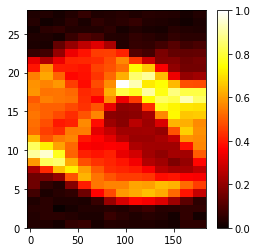

In [355]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_data[0].shape)       
fig, axis = plt.subplots(1, 1, figsize=(4,4))
dx, dy = 0.5 * 180.0 / 28, 0.5 / 28
im = axis.imshow(example_data[2], cmap='hot',
        extent=(-dx, 180.0 + dx, -dy, 28 + dy),
        aspect='auto')
fig.colorbar(im)                   

<class 'torch.Tensor'>


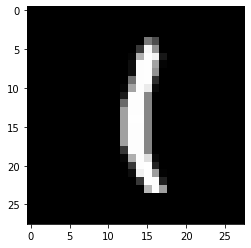

In [356]:
print(type(example_targets[0]))
plt.imshow(example_targets[0], cmap = 'gray')

In [357]:
import torch.nn.functional as F
import torch.optim as optim

In [358]:
from skimage.transform import radon,iradon

#Function to return Radon transformation matrix
def getRadonMatrix(theta,ny,nx):
    test = radon(np.zeros((ny,nx)) , theta=theta)
    A = np.zeros((test.size,ny*nx))
    for i in range(ny):
        for j in range(nx):
            image = np.zeros((ny,nx)) 
            image[i,j]=1
            sinogram = radon(image, theta=theta)
            A[:,j+i*nx] = np.reshape(sinogram,A.shape[0])
            
    return A


In [359]:
#Defining 14 angular projection positions for X-ray.

theta = np.linspace(0., 180., 14, endpoint=False)
A = getRadonMatrix(theta,28,28)
A_inv = np.linalg.pinv(A)
print(A.shape)
print(A_inv.shape)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not stri

(392, 784)
(784, 392)


In [360]:

#Calculating Psnr and SSIM values for image reconstructed using Pseudoinverse and Filtered Back Projection
psnr_fbp_train =[]
psnr_fbp_validation =[]
Psnr_pseudo_train =[]
Psnr_pseudo_val =[]
ssi_fbp =[]
ssi_inv =[]
for i in range(len(train_dataset)):
  reconst_fbp = iradon(train_dataset [i][0].numpy(), theta=theta, filter='ramp')  
  pseudo_inv =np.dot(A_inv,np.reshape(train_dataset [0][0].numpy(),(A.shape[0],1) )) 
  pseudo_inv_reshaped = np.reshape( pseudo_inv, (28,28))
  ssi_filtered_BP= ssim(train_dataset [i][1].numpy(),    reconst_fbp, data_range=   reconst_fbp.max()-   reconst_fbp.min())
  ssi_inverse= ssim(train_dataset [i][1].numpy(),  pseudo_inv_reshaped, data_range= pseudo_inv_reshaped.max()- pseudo_inv_reshaped.min())
  psnr_ = peak_signal_noise_ratio(train_dataset [i][1].numpy(),reconst_fbp)
  psnr_inv = peak_signal_noise_ratio(train_dataset [i][1].numpy(), pseudo_inv_reshaped)
  psnr_fbp_train.append(psnr_)
  Psnr_pseudo_train.append(psnr_inv)
  ssi_fbp.append(ssi_filtered_BP)
  ssi_inv.append(ssi_inverse)


for i in range(len(validation_dataset)):
  reconst_fbp = iradon(validation_dataset [i][0].numpy(), theta=theta, filter='ramp') 
  pseudo_inv =np.dot(A_inv,np.reshape(validation_dataset [i][0].numpy(),(A.shape[0],1) )) 
  pseudo_inv_reshaped = np.reshape( pseudo_inv, (28,28))
  psnr_ = peak_signal_noise_ratio(validation_dataset [i][1].numpy(),reconst_fbp)
  psnr_inv = peak_signal_noise_ratio(train_dataset [i][1].numpy(), pseudo_inv_reshaped)
  psnr_fbp_validation.append(psnr_)
  Psnr_pseudo_val.append(psnr_inv)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


9.720633753847643
0.015868675721453684


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  after removing the cwd from sys.path.


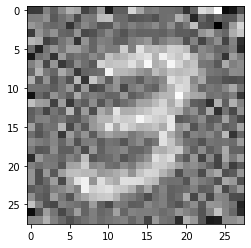

In [361]:
#Plotting image reconstructed using Pseudoinverse
pseudo_inv =np.dot(A_inv,np.reshape(train_dataset [7][0].numpy(),(A.shape[0],1) )) 
pseudo_inv_reshaped = np.reshape( pseudo_inv, (28,28))
psnr_inv = peak_signal_noise_ratio(train_dataset [0][1].numpy(), pseudo_inv_reshaped)
ssi_inverse= ssim(train_dataset [0][1].numpy(),  pseudo_inv_reshaped, data_range= pseudo_inv_reshaped.max()- pseudo_inv_reshaped.min())
print(psnr_inv)
print(ssi_inverse)
plt.imshow(np.reshape(pseudo_inv, (28,28)),cmap="gray")


9.720106992232745
0.02321844539727196


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  This is separate from the ipykernel package so we can avoid doing imports until


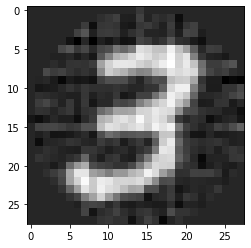

In [362]:
#Plotting image reconstructed using Filtered Back Projection
reconst_fbp = iradon(train_dataset [7][0].numpy(), theta=theta, filter='ramp') 
psnr_ = peak_signal_noise_ratio(train_dataset [0][1].numpy(),reconst_fbp)
ssi_filtered_BP= ssim(train_dataset [0][1].numpy(), reconst_fbp, data_range=   reconst_fbp.max()-   reconst_fbp.min())
print(psnr_)
print(ssi_filtered_BP)
plt.imshow( reconst_fbp, cmap = "gray")


In [363]:
from skimage.transform import radon,rescale,resize

theta = np.linspace(0., 180., 14, endpoint=False)
A = getRadonMatrix(theta,28,28)

#Class to carryout matrix multiplication within the Neural Network
class size_change():
  def __init__(self,batch_size, num_channels,nx,ny):
    self.batch_size = batch_size
    self.num_channels = num_channels
    self.shape_x = nx
    self.shape_y = ny
    self.transpose_A = A.T

  def Mul_AT(self,x):
    output = torch.empty(self.batch_size, self.num_channels, 28, 28).to(device)
    for i in range(self.batch_size):
      for j in range(self.num_channels):
        output[i][j] = torch.reshape(torch.matmul(torch.from_numpy(self.transpose_A).to(device), torch.reshape(x[i][j].double(),(A.shape[0],1))),
                                     (28,28))
    return output


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
/usr/local/lib/python3.7/dist-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not stri

In [364]:
#This cell consists of Different experimented Network Architecture's
#Please uncomment the required network architecture to run the code


#Size change matrix multiplication done between  2nd and 3rd layer
#Best among the network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels =1 , out_channels = 25, kernel_size=2, stride = 1)  # =>ouput dim=27,13
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=1, kernel_size=2, stride =1, padding =1) # =>ouput dim=28,14
        # multiplying the output of 28,14 with A transpose
        self.size_change = size_change(batch_size_train,1,28,14) 
        # New dimension after multiplication is (28,28) 
        self.conv3 = nn.Conv2d(in_channels=1, out_channels= 25, kernel_size=2, stride =1) # =>output dim= 27,27   
        self.drop_1 = nn.Dropout2d(p = 0.4)                                                                                                                                                   
        self.conv4 = nn.Conv2d(in_channels=25, out_channels =25, kernel_size=2, stride = 1,padding =1) #=>output dim= 28,28
        self.drop2 = nn.Dropout2d(p =0.4)
        self.conv5 = nn.Conv2d(in_channels=25, out_channels = 25, kernel_size=2, stride = 1) # =>output dim= 27,27     
        #self.drop3 = nn.Dropout2d(p =0.2)                                                                                                                                       
        self.conv6 = nn.Conv2d(in_channels=25, out_channels= 1, kernel_size=2, stride = 1,padding =1) #=> output dim =28,28

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        # multiplying the output of 28,14 with A transpose
        x = self.size_change.Mul_AT(x)
        # New dimension after multiplication is (28,28)
        x = self.conv3(x)
        x = self.drop_1(x)
        x = F.relu(self.conv4(x))
        x = self.drop2(x)
        x = F.relu(self.conv5(x))
        #x = self.drop3(x)
        x = F.relu(self.conv6(x))
        
        return x
  



"""

#Size change matrix multiplication done at first layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # multiplying the with A transpose
        self.size_change = size_change(batch_size_train,1,28,14) #=> 28*14 gets converted to 28*28
        self.conv1 = nn.Conv2d(in_channels =1 , out_channels = 25, kernel_size=2, stride = 1)  # =>ouput dim=27,27
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=2, stride =1, padding =1) # =>ouput dim=28,28
        self.conv3 = nn.Conv2d(in_channels=25, out_channels= 25, kernel_size=2, stride =1) # =>output dim= 27,27   
        self.drop_1 = nn.Dropout2d(p = 0.2)                                                                                                                                                   
        self.conv4 = nn.Conv2d(in_channels=25, out_channels =25, kernel_size=2, stride = 1,padding =1) #=>output dim= 28,28
        self.drop2 = nn.Dropout2d(p =0.2)
        self.conv5 = nn.Conv2d(in_channels=25, out_channels = 25, kernel_size=2, stride = 1) # =>output dim= 27,27     
        self.drop3 = nn.Dropout2d(p =0.2)                                                                                                                                       
        self.conv6 = nn.Conv2d(in_channels=25, out_channels= 1, kernel_size=2, stride = 1,padding =1) #=> output dim =28,28

        
    def forward(self, x):
        # multiplying the output of 28,14 with A transpose
        x = self.size_change.Mul_AT(x)
        # New dimension after multiplication is (28,28)
        x = F.relu(self.conv1(x))
        x = self.conv2(x) 
        x = self.conv3(x)
        #x = self.drop_1(x)
        x = F.relu(self.conv4(x))
        x = self.drop2(x)
        x = F.relu(self.conv5(x))
        #x = self.drop3(x)
        x = F.relu(self.conv6(x))
        
        return x



"""



"""
#Size change matrix multiplication done between 4th and 5th layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels =1 , out_channels = 25, kernel_size=2, stride = 1)  # =>ouput dim=27,13
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=2, stride =1, padding =1) # =>ouput dim=28,14
        

        self.drop_1 = nn.Dropout2d(p = 0.2)
        self.conv3 = nn.Conv2d(in_channels=25, out_channels= 25, kernel_size=2, stride =1) # =>output dim= 27,13                                                                                                                                                     
        self.conv4 = nn.Conv2d(in_channels=25, out_channels =25, kernel_size=2, stride = 1,padding =1) #=>output dim= 28,14
        # multiplying the output of 28,14 with A transpose
        self.size_change = size_change(batch_size_train,1,28,14) 
        # New dimension after multiplication is (28,28) 
        #self.drop2 = nn.Dropout2d(p =0.2)
        self.conv5 = nn.Conv2d(in_channels=1, out_channels = 25, kernel_size=2, stride = 1) # =>output dim= 27,27     
        self.drop3 = nn.Dropout2d(p =0.2)                                                                                                                                        
        self.conv6 = nn.Conv2d(in_channels=25, out_channels= 1, kernel_size=2, stride = 1,padding =1) #=> output dim =28,28

        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.drop_1(x)
        x = self.conv3(x)
        x = F.relu(self.conv4(x))
        # multiplying the output of 28,14 with A transpose
        x = self.size_change.Mul_AT(x)
        # New dimension after multiplication is (28,28)
        #x = self.drop2(x)
        x = F.relu(self.conv5(x))
        x = self.drop3(x)
        x = F.relu(self.conv6(x))
        
        return x
 
"""


"""
#Size change matrix multiplication done at 6th layer
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels =1 , out_channels = 25, kernel_size=2, stride = 1)  # =>ouput dim=27,13
        self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=2, stride =1, padding =1) # =>ouput dim=28,14
        self.conv3 = nn.Conv2d(in_channels=25, out_channels= 25, kernel_size=2, stride =1) # =>output dim= 27,13  
        self.drop_1 = nn.Dropout2d(p = 0.2)                                                                                                                                                   
        self.conv4 = nn.Conv2d(in_channels=25, out_channels =25, kernel_size=2, stride = 1,padding =1) #=>output dim= 28,14
        self.drop2 = nn.Dropout2d(p =0.2)
        self.conv5 = nn.Conv2d(in_channels=25, out_channels = 25, kernel_size=2, stride = 1) # =>output dim= 27,13     
        self.drop3 = nn.Dropout2d(p =0.2)                     #self.drop3 = nn.Dropout2d(p =0.2)                                                                                                                    
        self.conv6 = nn.Conv2d(in_channels=25, out_channels= 1, kernel_size=2, stride = 1,padding =1) #=> output dim =28,14
        # multiplying the output of 28,14 with A transpose
        self.size_change = size_change(batch_size_train,1,28,14) 
        # New dimension after multiplication is (28,28) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.drop_1(x)
        x = F.relu(self.conv4(x))
        x = self.drop2(x)
        x = F.relu(self.conv5(x))
        #x = self.drop3(x)
        x = F.relu(self.conv6(x))
        # multiplying the output of 28,14 with A transpose
        x = self.size_change.Mul_AT(x)
        # New dimension after multiplication is (28,28)
        return x
"""




'\n#Size change matrix multiplication done between 4th and 5th layer\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(in_channels =1 , out_channels = 25, kernel_size=2, stride = 1)  # =>ouput dim=27,13\n        self.conv2 = nn.Conv2d(in_channels=25, out_channels=25, kernel_size=2, stride =1, padding =1) # =>ouput dim=28,14\n        self.conv3 = nn.Conv2d(in_channels=25, out_channels= 25, kernel_size=2, stride =1) # =>output dim= 27,13  \n        self.drop_1 = nn.Dropout2d(p = 0.2)                                                                                                                                                   \n        self.conv4 = nn.Conv2d(in_channels=25, out_channels =25, kernel_size=2, stride = 1,padding =1) #=>output dim= 28,14\n        self.drop2 = nn.Dropout2d(p =0.2)\n        self.conv5 = nn.Conv2d(in_channels=25, out_channels = 25, kernel_size=2, stride = 1) # =>output dim= 27,13     \n        s

In [365]:
model = Net()
model = model.to(device)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     # momentum=momentum)
optimizer = optim.Adam(model.parameters())

In [366]:
train_losses = []
validation_losses =[]
psnr_skimetric_lst =[]
epoch_loss_train = []
epoch_loss_val =[]
psnr_formula_per_epoch_train =[]
psnr_formula_per_epoch_val =[]
psnr_formula_per_epoch_train_45 =[]
psnr_formula_per_epoch_val_45 =[]
psnr_TRAIN_batch =[]
psnr_VAL_batch =[]
psnr_train_lst =[]
psnr_val_lst =[]
ssi_train =[]
ssi_val =[]
ssi_train_batch =[]
ssi_val_batch =[]
ssi_per_epoch_train =[]
ssi_per_epoch_val =[]
TV =[]


In [367]:
# Defining the Mean Square Error Loss
loss_function = nn.MSELoss()

In [368]:
#training loop
def train(epoch):
    model.train()
    Alpha = 0.0005   # Regularisation hyperparameter
    running_loss_train = 0.0
    running_loss_val = 0.0
    running_psnr_train = 0.0
    running_psnr_val = 0.0
    running_ssi_train =0.0
    running_ssi_val =0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.view(batch_size_train,1,28,14)
        target = target.view(batch_size_train,1,28,28)
        data = data.float() #Reading images gives integer values
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = loss_function(output, target)
        #Regularization
        total_variation = k.losses.total_variation(output).mean()
        #print("TV: ", total_variation) 
        TV.append(total_variation.detach().cpu().numpy())
        loss = loss + Alpha *total_variation
        loss.backward()
        optimizer.step()
        
        running_loss_train += loss.item()
        for i in range(batch_size_train):
           psnr_train = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(), output[i][0].cpu().detach().numpy()) #  data_range= output.cpu().detach().numpy().max()
           psnr_train_lst.append(psnr_train)
           running_psnr_train += psnr_train
           ssindex_train= ssim(target[i][0].detach().cpu().numpy(),  output[i][0].detach().cpu().numpy(), data_range=output[i][0].detach().cpu().numpy().max()- output[i][0].detach().cpu().numpy().min())
           ssi_train.append(ssindex_train)
           running_ssi_train += ssindex_train
           if i == 0:
             psnr_current =  psnr_train
             ssi_current = ssindex_train
           if i == batch_size_train:
             psnr = psnr_train
             ssi = ssindex_train
             

        psnr_TRAIN_batch.append(psnr_train)
        ssi_train_batch.append(ssi_train)

        if batch_idx % (log_interval *12) == 0:
          print("psnr skimetirc:", psnr_current,"dB")
          print("SSI of the image:",ssi_current)
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_dataset),
          100. * batch_idx / len(train_loader), loss.item()))
          train_losses.append(loss.item())
         
    psnr_epoch_train = running_psnr_train/(batch_idx*batch_size_train)
    ssi_epoch_train = running_ssi_train/(batch_idx*batch_size_train)
    print("PSNR value for training of epoch:",epoch,"=>", psnr_epoch_train)
    print("SSI value for training of epoch:",epoch,"=>", ssi_epoch_train )
    psnr_formula_per_epoch_train.append(psnr_epoch_train)
    ssi_per_epoch_train.append(ssi_epoch_train)
    train_loss_per_epoch = (running_loss_train)/(len(train_loader))
    epoch_loss_train.append(train_loss_per_epoch)
    print("====================================>Loss per train epoch:",np.mean(epoch_loss_train))
    model.eval()
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(validation_loader):
        data = data.to(device)
        target = target.to(device)
        data = data.view(batch_size_val,1,28,14)
        target = target.view(batch_size_val,1,28,28)
        data = data.float()
        output = model(data)
        loss = loss_function(output, target)
        
        #Regularization
        total_variation = k.losses.total_variation(output).mean()
        loss = loss + Alpha *total_variation
        running_loss_val += loss.item()



# Validating for every epoch
        for i in range(batch_size_val):
           psnr_val = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(), output[i][0].cpu().detach().numpy()) 
           psnr_val_lst.append(psnr_val)
           running_psnr_val += psnr_val
           ssindex_val= ssim(target[i][0].detach().cpu().numpy(),  output[i][0].detach().cpu().numpy(), data_range=output[i][0].detach().cpu().numpy().max()- output[i][0].detach().cpu().numpy().min())
           ssi_val.append(ssindex_val)
           running_ssi_val += ssindex_val
           if i == 0:
             psnr_current =  psnr_val
             ssi_current = ssindex_val
           if i == batch_size_val:
             psnr = psnr_val
             ssi = ssindex_val
        psnr_VAL_batch.append(psnr_val)
        ssi_val_batch.append(ssindex_val)
       
       
        if batch_idx % 100 == 0:
          print("psnr by skimetric:",  psnr_current,"dB")
          print("SSI of the image:",ssindex_val )
          print('Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(validation_dataset),
          100. * batch_idx / len(validation_loader), loss.item()))

          validation_losses.append(loss.item())
    psnr_epoch_val = running_psnr_val/(batch_idx * batch_size_val)
    ssi_epoch_val = running_ssi_val/(batch_idx*batch_size_val)
    print("PSNR value for validation of",epoch,"th epoch:", psnr_epoch_val,"dB")
    print("SSI value for validation of",epoch,"th epoch:", ssi_current)
    psnr_formula_per_epoch_val.append(psnr_epoch_val)
    ssi_per_epoch_val.append(ssi_epoch_val)
    val_loss_per_epoch = (running_loss_val)/(len(validation_loader))
    epoch_loss_val.append(val_loss_per_epoch)
    print("============================================>Loss per val epoch:",np.mean(epoch_loss_train))



In [369]:
for epoch in range(1, n_epochs + 1):
    train(epoch)


psnr skimetirc: 12.66318498287437 dB
SSI of the image: 0.002863706021227646
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.112798
psnr skimetirc: 11.366822983882685 dB
SSI of the image: 0.12684927010787816
Train Epoch: 1 [2400/60000 (4%)]	Loss: 0.064122
psnr skimetirc: 12.583755120525517 dB
SSI of the image: 0.027973078632056825
Train Epoch: 1 [4800/60000 (8%)]	Loss: 0.066636
psnr skimetirc: 15.35700765684523 dB
SSI of the image: 0.49077408678849194
Train Epoch: 1 [7200/60000 (12%)]	Loss: 0.059417
psnr skimetirc: 16.50184670794274 dB
SSI of the image: 0.33984645827876325
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.051730
psnr skimetirc: 17.6344450249478 dB
SSI of the image: 0.7671421841374494
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.050113
psnr skimetirc: 16.814355055390333 dB
SSI of the image: 0.524135269026104
Train Epoch: 1 [14400/60000 (24%)]	Loss: 0.049625
psnr skimetirc: 18.542064528233006 dB
SSI of the image: 0.7093123401126132
Train Epoch: 1 [16800/60000 (28%)]	Loss: 0.051520
psnr skime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


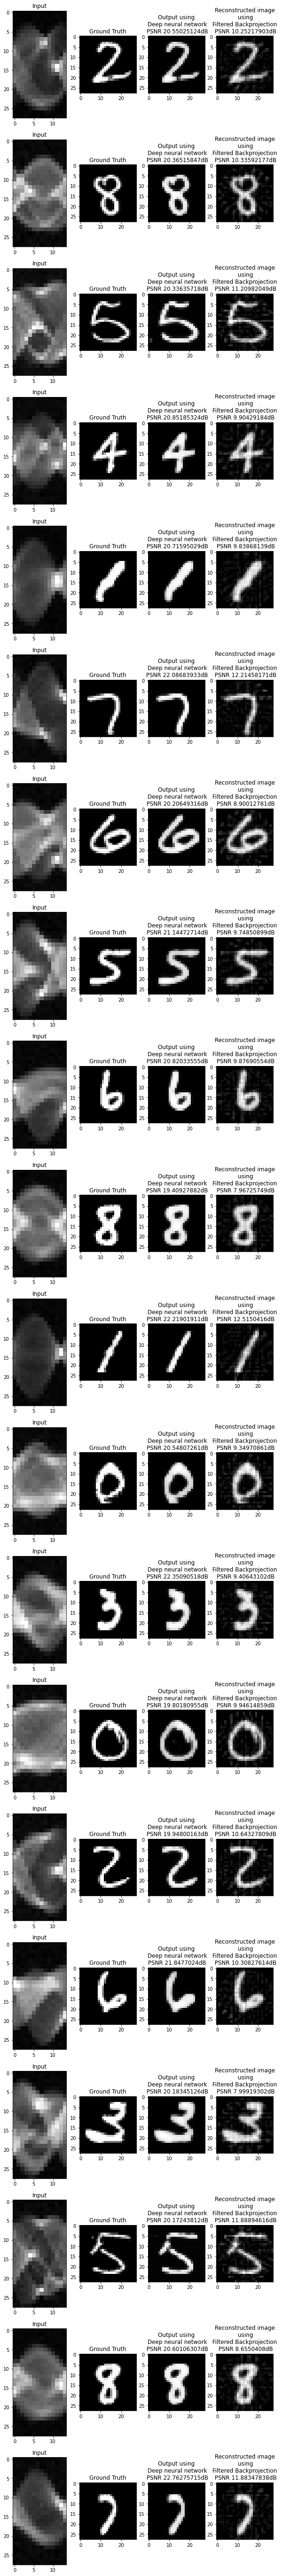

In [384]:
#Printing the results using train data
train_op = enumerate(train_loader)
batch_idx, (data, target) = next(train_op)
with torch.no_grad():
    optimizer.zero_grad()
    data = data.to(device)
    target = target.to(device)
    data = data.view(batch_size_train,1,28,14)
    target = target.view(batch_size_train,1,28,28)
    data = data.float()
    output = model(data)
    loss = loss_function(output, target)
    plt.figure(figsize=(10,100))
    fbp =[]
    psnr_ =[]
    for i in range(len(data)):
      psnr_skimetric = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(), output[i][0].cpu().detach().numpy())
      psnr_.append(psnr_skimetric)
      ssim_1= ssim(target[i][0].detach().cpu().numpy(),  output[i][0].detach().cpu().numpy(), data_range=output[i][0].detach().cpu().numpy().max()- output[i][0].detach().cpu().numpy().min()) 
      reconstruction_fbp =np.clip(iradon(data[i][0].cpu().detach().numpy(), theta=theta, filter='ramp'),0,1)
      fbp.append(reconstruction_fbp)
      psnr_fbp = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(),reconstruction_fbp)
      plt.subplot(20,4,(4*i+1))
      plt.imshow(data[i][0].cpu(),cmap = 'gray' )
      plt.title("Input")
      plt.subplot(20,4,(4*i+2))
      plt.imshow(target[i][0].cpu(),cmap = 'gray')
      plt.title("Ground Truth")
      plt.subplot(20,4,(4*i+3))
      plt.imshow(output[i][0].cpu(),cmap = 'gray')
      plt.title("Output using\n Deep neural network\n PSNR {}dB".format(round(psnr_skimetric,8)))
      plt.subplot(20,4,(4*i+4))
      plt.imshow(fbp[i],cmap = 'gray')
      plt.title("Reconstructed image\n using\n Filtered Backprojection \n PSNR {}dB".format(round(psnr_fbp, 8)))

plt.savefig("RAML_output_regulari_0.00005.png")


In [371]:
def test(epoch):
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.to(device)
            target = target.to(device)
            data = data.view(batch_size_test,1,28,14)
            target = target.view(batch_size_test,1,28,28)
            data = data.float()
            output = model(data)
            loss = loss_function(output, target)
            if batch_idx % 10 == 0:
                print('Test Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(test_loader.dataset),
                100. * batch_idx / len(test_loader), loss.item()))
              
  

In [372]:
#Test loop
for epoch in range(1, n_epochs + 1):
    test(epoch)

Test Epoch: 1 [0/5000 (0%)]	Loss: 0.008557
Test Epoch: 1 [200/5000 (4%)]	Loss: 0.008258
Test Epoch: 1 [400/5000 (8%)]	Loss: 0.008214
Test Epoch: 1 [600/5000 (12%)]	Loss: 0.007557
Test Epoch: 1 [800/5000 (16%)]	Loss: 0.007958
Test Epoch: 1 [1000/5000 (20%)]	Loss: 0.008719
Test Epoch: 1 [1200/5000 (24%)]	Loss: 0.008912
Test Epoch: 1 [1400/5000 (28%)]	Loss: 0.007892
Test Epoch: 1 [1600/5000 (32%)]	Loss: 0.009051
Test Epoch: 1 [1800/5000 (36%)]	Loss: 0.008989
Test Epoch: 1 [2000/5000 (40%)]	Loss: 0.007197
Test Epoch: 1 [2200/5000 (44%)]	Loss: 0.008179
Test Epoch: 1 [2400/5000 (48%)]	Loss: 0.007906
Test Epoch: 1 [2600/5000 (52%)]	Loss: 0.008104
Test Epoch: 1 [2800/5000 (56%)]	Loss: 0.008538
Test Epoch: 1 [3000/5000 (60%)]	Loss: 0.008231
Test Epoch: 1 [3200/5000 (64%)]	Loss: 0.008067
Test Epoch: 1 [3400/5000 (68%)]	Loss: 0.008673
Test Epoch: 1 [3600/5000 (72%)]	Loss: 0.009077
Test Epoch: 1 [3800/5000 (76%)]	Loss: 0.008650
Test Epoch: 1 [4000/5000 (80%)]	Loss: 0.008249
Test Epoch: 1 [4200/500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


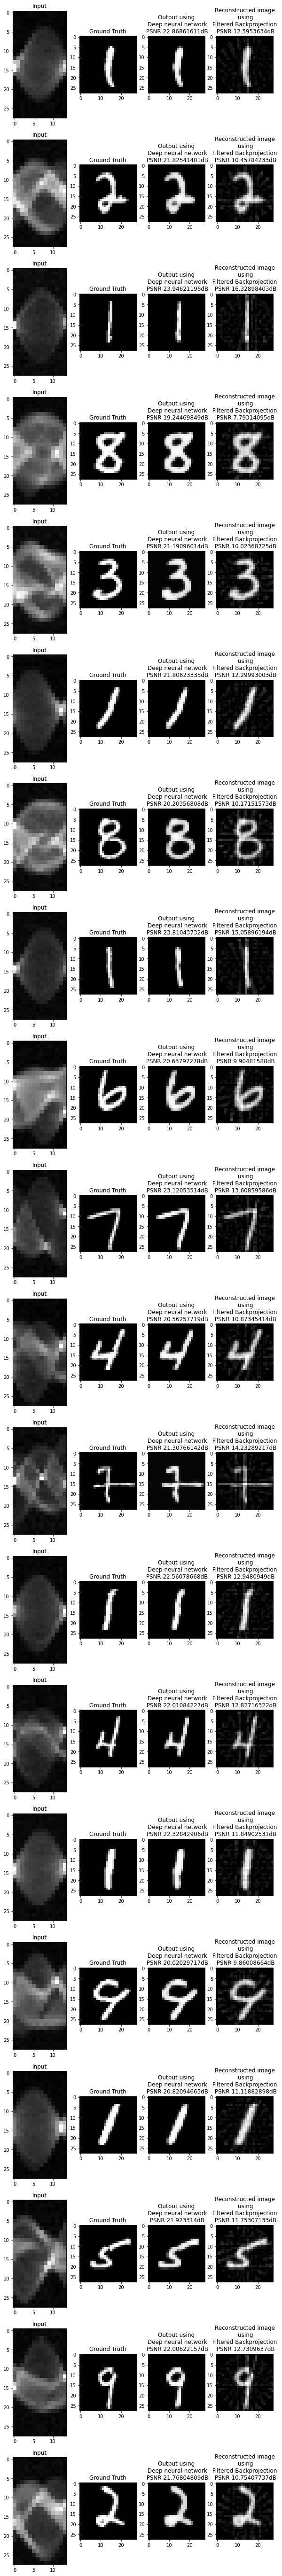

In [373]:
#Printing the results using test data
test_op = enumerate(test_loader)
batch_idx, (data, target) = next(test_op)
with torch.no_grad():
    optimizer.zero_grad()
    data = data.to(device)
    target = target.to(device)
    data = data.view(batch_size_train,1,28,14)
    target = target.view(batch_size_train,1,28,28)
    data = data.float()
    output = model(data)
    loss = loss_function(output, target)
    plt.figure(figsize=(10,100))
    fbp =[]
    psnr_ =[]
    for i in range(len(data)):
      psnr_skimetric = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(), output[i][0].cpu().detach().numpy())
      psnr_.append(psnr_skimetric)
      ssim_1= ssim(target[i][0].detach().cpu().numpy(),  output[i][0].detach().cpu().numpy(), data_range=output[i][0].detach().cpu().numpy().max()- output[i][0].detach().cpu().numpy().min()) 
      reconstruction_fbp =np.clip(iradon(data[i][0].cpu().detach().numpy(), theta=theta, filter='ramp'),0,1)
      fbp.append(reconstruction_fbp)
      psnr_fbp = peak_signal_noise_ratio(target[i][0].cpu().detach().numpy(),reconstruction_fbp)
      plt.subplot(20,4,(4*i+1))
      plt.imshow(data[i][0].cpu(),cmap = 'gray' )
      plt.title("Input")
      plt.subplot(20,4,(4*i+2))
      plt.imshow(target[i][0].cpu(),cmap = 'gray')
      plt.title("Ground Truth")
      plt.subplot(20,4,(4*i+3))
      plt.imshow(output[i][0].cpu(),cmap = 'gray')
      plt.title("Output using\n Deep neural network\n PSNR {}dB".format(round(psnr_skimetric,8)))
      plt.subplot(20,4,(4*i+4))
      plt.imshow(fbp[i],cmap = 'gray')
      plt.title("Reconstructed image\n using\n Filtered Backprojection \n PSNR {}dB".format(round(psnr_fbp, 8)))

plt.savefig("RAML_output_regulari_0.00005.png")


<input>:13: DeprecationWarning: invalid escape sequence \C
<input>:13: DeprecationWarning: invalid escape sequence \C
<ipython-input-374-4a43612dde7f>:13: DeprecationWarning: invalid escape sequence \C
  plt.savefig('F:\Chrome downloads\loss_graph.png')


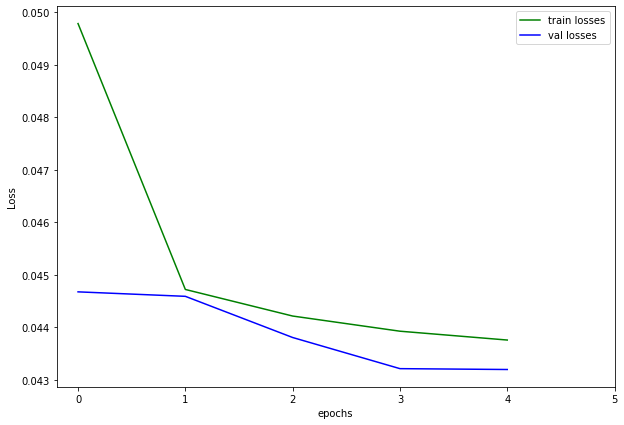

In [374]:
#Loss graph plotting
plt.figure(figsize=(10, 7))

plt.plot(epoch_loss_train, color='green', label='train losses')
plt.plot(epoch_loss_val, color='blue', label='val losses')
plt.xticks(range(n_epochs+1))
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()

plt.savefig('F:\Chrome downloads\loss_graph.png')
plt.show()


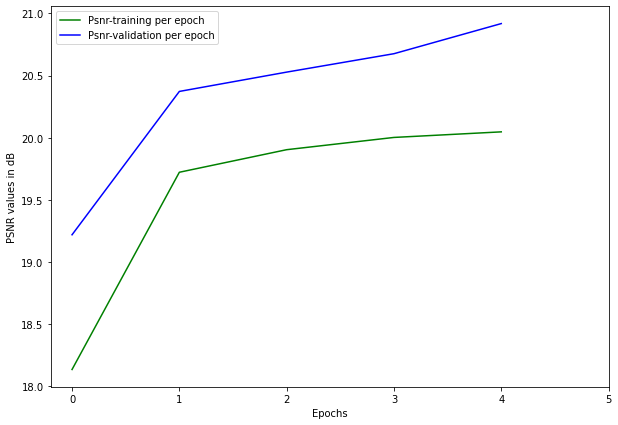

In [375]:
plt.figure(figsize=(10, 7))
plt.plot( psnr_formula_per_epoch_train, color='green', label='Psnr-training per epoch')
plt.plot( psnr_formula_per_epoch_val, color='blue', label='Psnr-validation per epoch')


plt.xticks(range(n_epochs+1))
plt.xlabel("Epochs")
plt.ylabel('PSNR values in dB')
plt.legend()
plt.show()




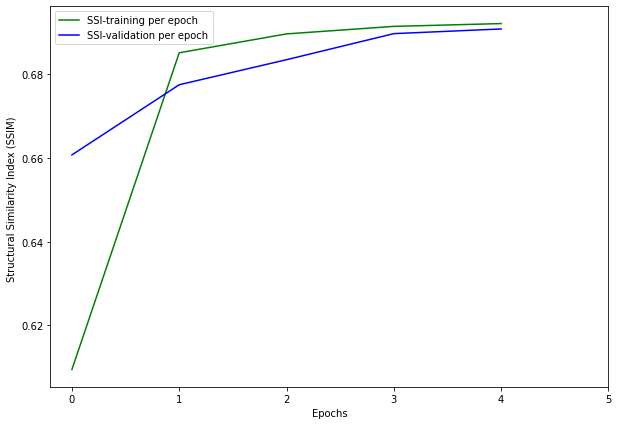

In [376]:
plt.figure(figsize=(10, 7))
plt.plot( ssi_per_epoch_train, color='green', label='SSI-training per epoch')
plt.plot( ssi_per_epoch_val, color='blue', label='SSI-validation per epoch')


plt.xticks(range(n_epochs+1))
plt.xlabel("Epochs")
plt.ylabel('Structural Similarity Index (SSIM) ')
plt.legend()
plt.show()



In [377]:
print(np.mean(psnr_train_lst))
print(np.min(psnr_train_lst))
print(np.max(psnr_train_lst))

19.555487306666066
5.010871276077371
26.349842410579857


In [378]:
print(np.mean(psnr_val_lst))
print(np.min(psnr_val_lst))
print(np.max(psnr_val_lst))

20.260883118068687
14.11826447915839
25.143411805350198


In [379]:
print(np.mean(ssi_train))
print(np.min(ssi_train))
print(np.max(ssi_train))



0.673336294170592
-0.01781236988873332
0.9653945040509417


In [380]:
print(np.mean(ssi_val))
print(np.min(ssi_val))
print(np.max(ssi_val))

0.6777313933474617
0.19898093581369544
0.9079330979126292


In [381]:
print(np.mean(ssi_per_epoch_train))
print(np.mean(ssi_per_epoch_val))

0.6735608144420739
0.6804532061721499


In [382]:
print(np.mean(psnr_formula_per_epoch_train))
print(np.mean(psnr_formula_per_epoch_val))

19.562007975991435
20.342252126574977
